## Imports

In [32]:
from book_rec_app import VespaApp
import pandas as pd
import openai
import os
from testes_modelos.llm_model import LLM_Model
import numpy as np
from vespa.io import VespaResponse, VespaQueryResponse
import matplotlib.pyplot as plt

## Deploy

In [2]:
app = VespaApp()

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for configuration server, 10/60 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 0/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 10/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 15/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 20/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 25/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Application is up!
Finished deplo

## Preparação para teste

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/bernardovma/dados_livros/main/data.csv")
books_df = df.sample(n=100)
books_df = books_df[['title', 'description', 'categories']]

In [4]:
#openai.api_key = ""
llm_model = LLM_Model(openai.api_key)

In [5]:
def dcg(relevance_scores, p):
    relevance_scores = np.asfarray(relevance_scores)[:p]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0

def ndcg(relevance_scores, p):
    dcg_p = dcg(relevance_scores, p)
    idcg_p = dcg(sorted(relevance_scores, reverse=True), p)
    if idcg_p == 0:
        return 0.0
    return dcg_p / idcg_p

In [6]:
def calculate_appearance_percentage(total_appearances, total_questions):
    if total_questions > 0:
        return (total_appearances / total_questions) * 100
    else:
        return 0

In [7]:
def calculate_ndcg_scores(results, p):
    ndcg_scores = {}
    for title, data in results.items():
        relevance_scores = data["relevance_scores"]
        ndcg_scores[title] = ndcg(relevance_scores, p)
    return np.mean(list(ndcg_scores.values()))

## BM25 Puro

In [8]:
results_bm_25 = {}
total_appearance_count_bm_25 = 0
total_questions_bm_25 = 0

In [19]:
if results_bm_25:
    last_title = list(results_bm_25.keys())[-1]
    last_book_data = results_bm_25.pop(last_title)
    total_appearance_count_bm_25 -= last_book_data["appearance_count"]
    total_questions_bm_25 -= last_book_data["total_questions"]


start_index = len(results_bm_25)
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_bm_25 = llm_model.generate_generic_questions(description, categories)
    
    results_bm_25[title] = {
        "questions": questions_bm_25,
        "appearance_count": 0,
        "total_questions": len(questions_bm_25),
        "relevance_scores": []
    }
    
    for question in questions_bm_25:
        search_results_bm_25 = app.query_bm25(question)
        search_results_titles_bm_25 = list(search_results_bm_25['title'])
        book_appears_bm_25 = title in search_results_titles_bm_25
        results_bm_25[title]["relevance_scores"].append(int(book_appears_bm_25))
        if book_appears_bm_25:
            results_bm_25[title]["appearance_count"] += 1
    
    total_appearance_count_bm_25 += results_bm_25[title]["appearance_count"]
    total_questions_bm_25 += results_bm_25[title]["total_questions"]

Processing book: Gold Bug Variations
Processing book: Sebastopol


## BM25 + Semântico

In [20]:
results_bm_25_semantico = {}
total_appearance_count_bm_25_semantico  = 0
total_questions_bm_25_semantico  = 0

In [21]:
if results_bm_25_semantico:
    last_title = list(results_bm_25_semantico.keys())[-1]
    last_book_data = results_bm_25_semantico.pop(last_title)
    total_appearance_count_bm_25_semantico -= last_book_data["appearance_count"]
    total_questions_bm_25_semantico -= last_book_data["total_questions"]


start_index = len(results_bm_25_semantico)
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_bm_25_semantico = llm_model.generate_generic_questions(description, categories)
    
    results_bm_25_semantico[title] = {
        "questions": questions_bm_25_semantico,
        "appearance_count": 0,
        "total_questions": len(questions_bm_25_semantico),
        "relevance_scores": []
    }
    
    for question in questions_bm_25_semantico:
        search_results_bm_25_semantico = app.query_second_phase(question)
        search_results_titles_bm_25_semantico = list(search_results_bm_25_semantico['title'])
        book_appears_bm_25_semantico = title in search_results_titles_bm_25_semantico
        results_bm_25_semantico[title]["relevance_scores"].append(int(book_appears_bm_25_semantico))
        if book_appears_bm_25_semantico:
            results_bm_25_semantico[title]["appearance_count"] += 1
    
    total_appearance_count_bm_25_semantico += results_bm_25_semantico[title]["appearance_count"]
    total_questions_bm_25_semantico += results_bm_25_semantico[title]["total_questions"]

Processing book: Exit the King, The Killer, and Macbett
Processing book: From Far Away
Processing book: Pop Internationalism
Processing book: The Charterhouse of Parma
Processing book: The Vampire Companion
Processing book: Happy Endings
Processing book: King Henry IV Part 2
Processing book: Kiss Kiss
Processing book: The Eye of the I
Processing book: Harry Potter and the Sorcerer's Stone (Book 1)
Processing book: Christian Mythmakers
Processing book: Dragondrums
Processing book: Redemption
Processing book: Send No Flowers
Processing book: Season of Mists
Processing book: Master of the Moon
Processing book: Cracks in My Foundation
Processing book: Close Range
Processing book: The Adventures of Tom Sawyer
Processing book: Go Ask Alice
Processing book: Cherries in the Snow
Processing book: Geisha
Processing book: Made in America
Processing book: Three Terrifying Bestselling Novels
Processing book: Lysistrata and Other Plays
Processing book: Anthonology
Processing book: The Cave
Processin

## Colbert Local

In [23]:
results_colbert_local = {}
total_appearance_count_colbert_local = 0
total_questions_colbert_local = 0

In [24]:
if results_colbert_local:
    last_title = list(results_colbert_local.keys())[-1]
    last_book_data = results_colbert_local.pop(last_title)
    total_appearance_count_colbert_local -= last_book_data["appearance_count"]
    total_questions_colbert_local -= last_book_data["total_questions"]

start_index = len(results_colbert_local)
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_colbert_local = llm_model.generate_generic_questions(description, categories)
    
    results_colbert_local[title] = {
        "questions": questions_colbert_local,
        "appearance_count": 0,
        "total_questions": len(questions_colbert_local),
        "relevance_scores": []
    }
    
    for question in questions_colbert_local:
        
        search_results_colbert = app.query_colbert(question)
        search_results_titles_colbert = list(search_results_colbert['title'])
        
        book_appears_colbert = title in search_results_titles_colbert
        results_colbert_local[title]["relevance_scores"].append(int(book_appears_colbert))
        if book_appears_colbert:
            results_colbert_local[title]["appearance_count"] += 1
    
    total_appearance_count_colbert_local += results_colbert_local[title]["appearance_count"]
    total_questions_colbert_local += results_colbert_local[title]["total_questions"]

Processing book: Exit the King, The Killer, and Macbett
Processing book: From Far Away
Processing book: Pop Internationalism
Processing book: The Charterhouse of Parma
Processing book: The Vampire Companion
Processing book: Happy Endings
Processing book: King Henry IV Part 2
Processing book: Kiss Kiss
Processing book: The Eye of the I
Processing book: Harry Potter and the Sorcerer's Stone (Book 1)
Processing book: Christian Mythmakers
Processing book: Dragondrums
Processing book: Redemption
Processing book: Send No Flowers
Processing book: Season of Mists
Processing book: Master of the Moon
Processing book: Cracks in My Foundation
Processing book: Close Range
Processing book: The Adventures of Tom Sawyer
Processing book: Go Ask Alice
Processing book: Cherries in the Snow
Processing book: Geisha
Processing book: Made in America
Processing book: Three Terrifying Bestselling Novels
Processing book: Lysistrata and Other Plays
Processing book: Anthonology
Processing book: The Cave
Processin

## Colbert Global

In [25]:
results_colbert_global = {}
total_appearance_count_colbert_global = 0
total_questions_colbert_global = 0

In [26]:
if results_colbert_global:
    last_title = list(results_colbert_global.keys())[-1]
    last_book_data = results_colbert_global.pop(last_title)
    total_appearance_count_colbert_global -= last_book_data["appearance_count"]
    total_questions_colbert_global -= last_book_data["total_questions"]

start_index = len(results_colbert_global)
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_colbert_global = llm_model.generate_generic_questions(description, categories)
    
    results_colbert_global[title] = {
        "questions": questions_colbert_global,
        "appearance_count": 0,
        "total_questions": len(questions_colbert_global),
        "relevance_scores": []
    }
    
    for question in questions_colbert_global:
        
        search_results_colbert_global = app.query_colbert_global(question)
        search_results_titles_colbert_global = list(search_results_colbert_global['title'])
        
        book_appears_colbert_global = title in search_results_titles_colbert_global
        results_colbert_global[title]["relevance_scores"].append(int(book_appears_colbert_global))
        if book_appears_colbert_global:
            results_colbert_global[title]["appearance_count"] += 1
    
    total_appearance_count_colbert_global += results_colbert_global[title]["appearance_count"]
    total_questions_colbert_global += results_colbert_global[title]["total_questions"]

Processing book: Exit the King, The Killer, and Macbett
Processing book: From Far Away
Processing book: Pop Internationalism
Processing book: The Charterhouse of Parma
Processing book: The Vampire Companion
Processing book: Happy Endings
Processing book: King Henry IV Part 2
Processing book: Kiss Kiss
Processing book: The Eye of the I
Processing book: Harry Potter and the Sorcerer's Stone (Book 1)
Processing book: Christian Mythmakers
Processing book: Dragondrums
Processing book: Redemption
Processing book: Send No Flowers
Processing book: Season of Mists
Processing book: Master of the Moon
Processing book: Cracks in My Foundation
Processing book: Close Range
Processing book: The Adventures of Tom Sawyer
Processing book: Go Ask Alice
Processing book: Cherries in the Snow
Processing book: Geisha
Processing book: Made in America
Processing book: Three Terrifying Bestselling Novels
Processing book: Lysistrata and Other Plays
Processing book: Anthonology
Processing book: The Cave
Processin

## BM25/Semântico + Colbert Local

In [27]:
results_bm_25_semantico_colbert_local = {}
total_appearance_count_bm_25_semantico_colbert_local = 0
total_questions_bm_25_semantico_colbert_local = 0

In [28]:
if results_bm_25_semantico_colbert_local:
    last_title = list(results_bm_25_semantico_colbert_local.keys())[-1]
    last_book_data = results_bm_25_semantico_colbert_local.pop(last_title)
    total_appearance_count_bm_25_semantico_colbert_local -= last_book_data["appearance_count"]
    total_questions_bm_25_semantico_colbert_local -= last_book_data["total_questions"]


start_index = len(results_bm_25_semantico_colbert_local)
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_bm_25_semantico_colbert_local = llm_model.generate_generic_questions(description, categories)
    
    results_bm_25_semantico_colbert_local[title] = {
        "questions": questions_bm_25_semantico_colbert_local,
        "appearance_count": 0,
        "total_questions": len(questions_bm_25_semantico_colbert_local),
        "relevance_scores": []
    }
    
    for question in questions_bm_25_semantico_colbert_local:
        search_results_bm_25_semantico_colbert_local = app.query_colbert_2phase(question)
        search_results_titles_bm_25_semantico_colbert_local = list(search_results_bm_25_semantico_colbert_local['title'])
        book_appears_bm_25_semantico_colbert_local = title in search_results_titles_bm_25_semantico_colbert_local
        results_bm_25_semantico_colbert_local[title]["relevance_scores"].append(int(book_appears_bm_25_semantico_colbert_local))
        if book_appears_bm_25_semantico_colbert_local:
            results_bm_25_semantico_colbert_local[title]["appearance_count"] += 1
    
    total_appearance_count_bm_25_semantico_colbert_local += results_bm_25_semantico_colbert_local[title]["appearance_count"]
    total_questions_bm_25_semantico_colbert_local += results_bm_25_semantico_colbert_local[title]["total_questions"]

Processing book: Exit the King, The Killer, and Macbett
Processing book: From Far Away
Processing book: Pop Internationalism
Processing book: The Charterhouse of Parma
Processing book: The Vampire Companion
Processing book: Happy Endings
Processing book: King Henry IV Part 2
Processing book: Kiss Kiss
Processing book: The Eye of the I
Processing book: Harry Potter and the Sorcerer's Stone (Book 1)
Processing book: Christian Mythmakers
Processing book: Dragondrums
Processing book: Redemption
Processing book: Send No Flowers
Processing book: Season of Mists
Processing book: Master of the Moon
Processing book: Cracks in My Foundation
Processing book: Close Range
Processing book: The Adventures of Tom Sawyer
Processing book: Go Ask Alice
Processing book: Cherries in the Snow
Processing book: Geisha
Processing book: Made in America
Processing book: Three Terrifying Bestselling Novels
Processing book: Lysistrata and Other Plays
Processing book: Anthonology
Processing book: The Cave
Processin

## BM25/Semântico + Colbert Global

In [29]:
results_bm_25_semantico_colbert_global = {}
total_appearance_count_bm_25_semantico_colbert_global = 0
total_questions_bm_25_semantico_colbert_global = 0

In [30]:
if results_bm_25_semantico_colbert_global :
    last_title = list(results_bm_25_semantico_colbert_global .keys())[-1]
    last_book_data = results_bm_25_semantico_colbert_global .pop(last_title)
    total_appearance_count_bm_25_semantico_colbert_global  -= last_book_data["appearance_count"]
    total_questions_bm_25_semantico_colbert_global  -= last_book_data["total_questions"]


start_index = len(results_bm_25_semantico_colbert_global )
books_to_process = books_df.iloc[start_index:]

for index, row in books_to_process.iterrows():
    title = row['title']
    print(f"Processing book: {title}")
    description = row['description']
    categories = row['categories']
    questions_bm_25_semantico_colbert_global  = llm_model.generate_generic_questions(description, categories)
    
    results_bm_25_semantico_colbert_global [title] = {
        "questions": questions_bm_25_semantico_colbert_global,
        "appearance_count": 0,
        "total_questions": len(questions_bm_25_semantico_colbert_global ),
        "relevance_scores": []
    }
    
    for question in questions_bm_25_semantico_colbert_global :
        search_results_bm_25_semantico_colbert_global = app.query_colbert_2phase_global(question)
        search_results_titles_bm_25_semantico_colbert_global  = list(search_results_bm_25_semantico_colbert_global ['title'])
        book_appears_bm_25_semantico_colbert_global  = title in search_results_titles_bm_25_semantico_colbert_global 
        results_bm_25_semantico_colbert_global [title]["relevance_scores"].append(int(book_appears_bm_25_semantico_colbert_global))
        if book_appears_bm_25_semantico_colbert_global :
            results_bm_25_semantico_colbert_global [title]["appearance_count"] += 1
    
    total_appearance_count_bm_25_semantico_colbert_global  += results_bm_25_semantico_colbert_global [title]["appearance_count"]
    total_questions_bm_25_semantico_colbert_global  += results_bm_25_semantico_colbert_global [title]["total_questions"]

Processing book: Exit the King, The Killer, and Macbett
Processing book: From Far Away
Processing book: Pop Internationalism
Processing book: The Charterhouse of Parma
Processing book: The Vampire Companion
Processing book: Happy Endings
Processing book: King Henry IV Part 2
Processing book: Kiss Kiss
Processing book: The Eye of the I
Processing book: Harry Potter and the Sorcerer's Stone (Book 1)
Processing book: Christian Mythmakers
Processing book: Dragondrums
Processing book: Redemption
Processing book: Send No Flowers
Processing book: Season of Mists
Processing book: Master of the Moon
Processing book: Cracks in My Foundation
Processing book: Close Range
Processing book: The Adventures of Tom Sawyer
Processing book: Go Ask Alice
Processing book: Cherries in the Snow
Processing book: Geisha
Processing book: Made in America
Processing book: Three Terrifying Bestselling Novels
Processing book: Lysistrata and Other Plays
Processing book: Anthonology
Processing book: The Cave
Processin

## Métricas

In [31]:
# Calculate appearance percentage and NDCG scores
appearance_percentage_bm_25 = calculate_appearance_percentage(total_appearance_count_bm_25, total_questions_bm_25)
ndcg_score_bm_25 = calculate_ndcg_scores(results_bm_25, 10)

appearance_percentage_bm_25_semantico = calculate_appearance_percentage(total_appearance_count_bm_25_semantico, total_questions_bm_25_semantico)
ndcg_score_bm_25_semantico = calculate_ndcg_scores(results_bm_25_semantico, 10)

appearance_percentage_colbert_local = calculate_appearance_percentage(total_appearance_count_colbert_local, total_questions_colbert_local)
ndcg_score_colbert_local = calculate_ndcg_scores(results_colbert_local, 10)

appearance_percentage_colbert_global = calculate_appearance_percentage(total_appearance_count_colbert_global, total_questions_colbert_global)
ndcg_score_colbert_global = calculate_ndcg_scores(results_colbert_global, 10)

appearance_percentage_bm_25_semantico_colbert_local = calculate_appearance_percentage(total_appearance_count_bm_25_semantico_colbert_local, total_questions_bm_25_semantico_colbert_local)
ndcg_score_bm_25_semantico_colbert_local = calculate_ndcg_scores(results_bm_25_semantico_colbert_local, 10)

appearance_percentage_bm_25_semantico_colbert_global = calculate_appearance_percentage(total_appearance_count_bm_25_semantico_colbert_global, total_questions_bm_25_semantico_colbert_global)
ndcg_score_bm_25_semantico_colbert_global = calculate_ndcg_scores(results_bm_25_semantico_colbert_global, 10)

In [34]:

print(f"BM25: Appearance Percentage: {appearance_percentage_bm_25}% NDCG@10: {ndcg_score_bm_25}")
print(f"BM25 Semantico: Appearance Percentage: {appearance_percentage_bm_25_semantico}% NDCG@10: {ndcg_score_bm_25_semantico}")
print(f"ColBERT Local: Appearance Percentage: {appearance_percentage_colbert_local}% NDCG@10: {ndcg_score_colbert_local}")
print(f"ColBERT Global: Appearance Percentage: {appearance_percentage_colbert_global}% NDCG@10: {ndcg_score_colbert_global}")
print(f"BM25 Semantico + ColBERT Local: Appearance Percentage: {appearance_percentage_bm_25_semantico_colbert_local}% NDCG@10: {ndcg_score_bm_25_semantico_colbert_local}")
print(f"BM25 Semantico + ColBERT Global: Appearance Percentage: {appearance_percentage_bm_25_semantico_colbert_global}% NDCG@10: {ndcg_score_bm_25_semantico_colbert_global}")

BM25: Appearance Percentage: 3.1746031746031744% NDCG@10: 0.05181580296291102
BM25 Semantico: Appearance Percentage: 24.840764331210192% NDCG@10: 0.3377320350964913
ColBERT Local: Appearance Percentage: 48.37662337662338% NDCG@10: 0.6387227038815286
ColBERT Global: Appearance Percentage: 49.68354430379747% NDCG@10: 0.6633157952930611
BM25 Semantico + ColBERT Local: Appearance Percentage: 46.70846394984326% NDCG@10: 0.6222745707201621
BM25 Semantico + ColBERT Global: Appearance Percentage: 43.87096774193549% NDCG@10: 0.5982398235081756


## Plots

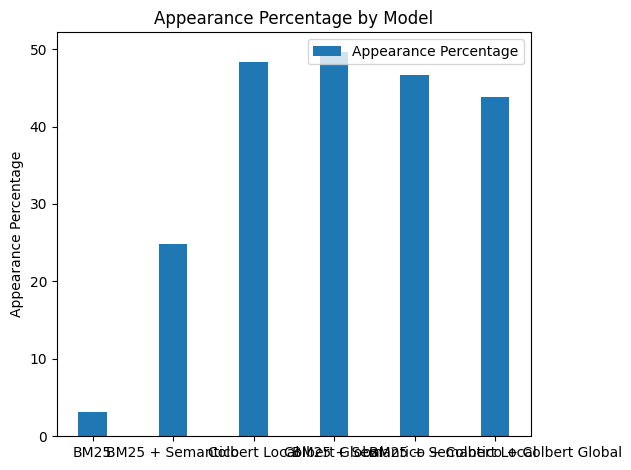

In [33]:
#plot das porcentagens
labels = ['BM25', 'BM25 + Semantico', 'Colbert Local', 'Colbert Global', 'BM25 + Semantico + Colbert Local', 'BM25 + Semantico + Colbert Global']
appearance_percentages = [appearance_percentage_bm_25, appearance_percentage_bm_25_semantico, appearance_percentage_colbert_local, appearance_percentage_colbert_global, appearance_percentage_bm_25_semantico_colbert_local, appearance_percentage_bm_25_semantico_colbert_global]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x, appearance_percentages, width, label='Appearance Percentage')

ax.set_ylabel('Appearance Percentage')
ax.set_title('Appearance Percentage by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()